In [2]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/PMML/tweets_mbg_fixed.csv")
df

df.head(100)


,Tweet ID,clean_text
0,1990828187006201982,kepala bgn ungkap penggunaan nitrin tinggi pen...
1,1990808795518546193,program mbg dorong pertumbuhan umkm tempe perm...
2,1990807038474006730,harta kekayaan cucun ahmad wakil ketua dpr per...
3,1990791277802394082,polemik mbg makin panas ahli gizi menyampaikan...
4,1990790947966447998,presiden brazil memerlukan 11 tahun mencapai 4...
...,...,...
64,1990590860149600507,kepala badan gizi nasional bgn dadan hindayana...
65,1990590582063051029,wabup deli serdang resmikan dapur sppg ujung r...
66,1990590520780075123,wakil ketua dpr cucun sebut anak muda arogan h...
67,1990588912621027362,makan bergizi gratis bukan hanya memenuhi gizi...


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
mt_name = "Helsinki-NLP/opus-mt-id-en"

mt_tokenizer = AutoTokenizer.from_pretrained(mt_name)
mt_model = AutoModelForSeq2SeqLM.from_pretrained(mt_name)
mt_model.to(device)
mt_model.eval()

def translate_id_to_en(text, max_length=128):
    """
    Terjemahkan teks Bahasa Indonesia -> Inggris.
    """
    if not isinstance(text, str) or text.strip() == "":
        return ""

    inputs = mt_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
    ).to(device)

    with torch.no_grad():
        outputs = mt_model.generate(
            **inputs,
            max_length=max_length,
            num_beams=4,
            early_stopping=True,
        )

    en_text = mt_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return en_text.strip()


# CONTOH CEK HASIL TERJEMAHAN
example_text = "IHSG Anjlok 1,4 Persen, Investor Asing Lepas Saham BBCA"
print("ID:", example_text)
print("EN:", translate_id_to_en(example_text))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/801k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/796k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/291M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/291M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

ID: IHSG Anjlok 1,4 Persen, Investor Asing Lepas Saham BBCA
EN: IHSG dropped 1.4 Percent, Foreign Investor Off BBCA Stock


In [5]:
# === TRANSLASI MASSAL UNTUK SEMUA TEKS DI KOLOM clean_text ===

from tqdm import tqdm
tqdm.pandas()

df["clean_text_en"] = df["clean_text"].progress_apply(translate_id_to_en)

# Cek hasil
df.head(10)



100%|██████████| 69/69 [01:48<00:00,  1.57s/it]


,Tweet ID,clean_text,clean_text_en
0,1990828187006201982,kepala bgn ungkap penggunaan nitrin tinggi pen...,head does not reveal the use of high nitrin ca...
1,1990808795518546193,program mbg dorong pertumbuhan umkm tempe perm...,Umkm tempe for soybeans to read another article.
2,1990807038474006730,harta kekayaan cucun ahmad wakil ketua dpr per...,Ahmad's fortune-funded vice-president dpr once...
3,1990791277802394082,polemik mbg makin panas ahli gizi menyampaikan...,Polemics are getting hotter. Nutrients convey ...
4,1990790947966447998,presiden brazil memerlukan 11 tahun mencapai 4...,Brazil's president requires 11 years to reach ...
5,1990755488422826100,mbg dongkrak permintaan kedelai umkm tempe tum...,Soy dong soy demand umkm tempe grow rapidly
6,1990746595206574462,lebih mahal dapur umum dpr pertanyakan anggara...,More expensive public kitchen dpr questioning ...
7,1990740446977409459,berkelanjutan berdaya saing melalui pembanguna...,continued power-sharing through development fo...
8,1990732740543549471,viral ucapkan mbg tak butuh ahli gizi waket dp...,Viral say mmg does not need a waket dpr grands...
9,1990729632090337547,berita2 bulan oktober yg cukup menarik dibahas,It's quite an interesting October story to dis...


In [6]:
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModelForSequenceClassification,
)
from torch.nn.functional import softmax

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

roberta_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_name)
roberta_model.to(device)
roberta_model.eval()

id2label = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

def roberta_sentiment_en(text, max_length=128):
    """
    Sentimen (positive/neutral/negative) + probabilitas tertinggi
    untuk kalimat bahasa Inggris menggunakan RoBERTa-base.
    """
    if not isinstance(text, str) or text.strip() == "":
        return "neutral", 0.0

    inputs = roberta_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding=True,
    ).to(device)

    with torch.no_grad():
        logits = roberta_model(**inputs).logits

    probs = softmax(logits, dim=1).cpu().numpy()[0]
    idx = probs.argmax()
    label = id2label[idx]
    prob = float(probs[idx])
    return label, prob

sample_en = "BBCA shares plunge 3 percent as foreign investors sell heavily"
print(sample_en, "->", roberta_sentiment_en(sample_en))


Using device: cpu


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

BBCA shares plunge 3 percent as foreign investors sell heavily -> ('negative', 0.6948140263557434)


In [8]:
from tqdm import tqdm
tqdm.pandas()

df["sentiment_result"] = df["clean_text_en"].progress_apply(roberta_sentiment_en)



100%|██████████| 69/69 [00:13<00:00,  4.97it/s]


In [9]:
df["Sentimen"] = df["sentiment_result"].apply(lambda x: x[0])
df["Prob"] = df["sentiment_result"].apply(lambda x: x[1])

In [10]:
df_final = df[["clean_text", "Sentimen", "Prob"]]
df_final

,clean_text,Sentimen,Prob
0,kepala bgn ungkap penggunaan nitrin tinggi pen...,negative,0.570926
1,program mbg dorong pertumbuhan umkm tempe perm...,neutral,0.821499
2,harta kekayaan cucun ahmad wakil ketua dpr per...,neutral,0.826667
3,polemik mbg makin panas ahli gizi menyampaikan...,negative,0.547203
4,presiden brazil memerlukan 11 tahun mencapai 4...,neutral,0.686170
...,...,...,...
64,kepala badan gizi nasional bgn dadan hindayana...,neutral,0.538197
65,wabup deli serdang resmikan dapur sppg ujung r...,neutral,0.866908
66,wakil ketua dpr cucun sebut anak muda arogan h...,negative,0.630723
67,makan bergizi gratis bukan hanya memenuhi gizi...,positive,0.903366


In [11]:
rata2 = df_final['Prob'].mean()
print(rata2)

0.7354596918043883


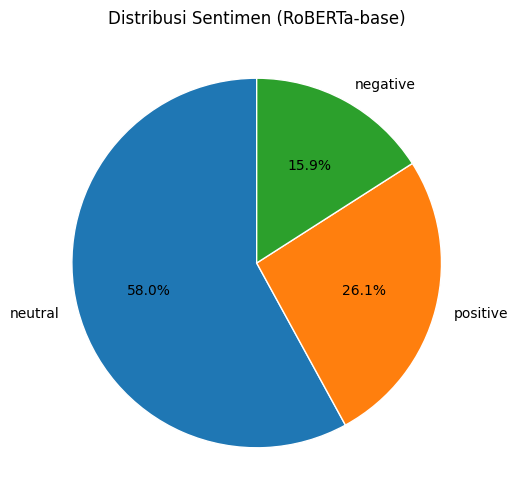

In [13]:
import matplotlib.pyplot as plt

# Hitung jumlah masing-masing sentimen
sentiment_counts = df_final["Sentimen"].value_counts()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
plt.title("Distribusi Sentimen (RoBERTa-base)")
plt.show()


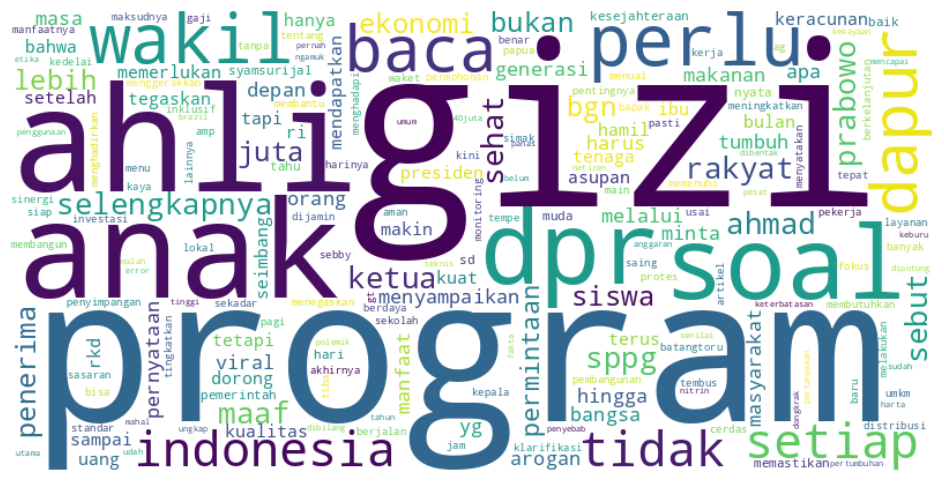

In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Gabungkan semua teks jadi satu string panjang
all_text = " ".join(df_final["clean_text"].astype(str))

# Stopwords dasar (bawaan wordcloud)
stopwords = set(STOPWORDS)

extra_stopwords = {
    "tak","cucun","t","co","https", "yang", "dan", "di", "ke", "untuk", "dengan",
    "ini", "itu", "akan", "pada", "para", "atau",
    "mbg", "makan", "bergizi", "gratis"  # kalau mau singkirkan kata2 ini
}
stopwords.update(extra_stopwords)

# Buat word cloud
wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=stopwords,
    collocations=False  # biar gak terlalu banyak frasa duplikat
).generate(all_text)

# Tampilkan
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [15]:
df_to_txt = df_final[["clean_text", "Sentimen", "Prob"]]

# Nama file
filename = "RoBERTa_MBG.txt"

# Tulis ke file .txt
with open(filename, "w", encoding="utf-8") as f:
    f.write("Tweet Analysis Output\n")
    f.write("=======================================\n\n")

    for idx, row in df_to_txt.iterrows():
        f.write(f"Row {idx+1}\n")
        f.write(f"Text  : {row['clean_text']}\n")
        f.write(f"Sentiment  : {row['Sentimen']}\n")
        f.write(f"Prob       : {row['Prob']}\n")
        f.write("---------------------------------------\n\n")

print(f"TXT saved as: {filename}")


TXT saved as: RoBERTa_MBG.txt
